<a href="https://colab.research.google.com/github/NidheshGomai/SETU/blob/main/notebook/train_yolov12_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sun Feb  1 10:36:13 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [3]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 63.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 147.8 MB/s eta 0:00:00


## Download dataset from Roboflow Universe

In [11]:

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="hh5Eu30kOzKGkAgvLfXg")
project = rf.workspace("smartathon").project("new-pothole-detection")
version = project.version(2)
dataset = version.download("yolov12")


loading Roboflow workspace...
loading Roboflow project...


In [5]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [6]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [7]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['Pothole']

roboflow:
  workspace: smartathon
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [12]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=50)

New https://pypi.org/project/ultralytics/8.4.9 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/New-pothole-detection-2/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=

train: Scanning /content/New-pothole-detection-2/train/labels.cache... 6091 images, 4 backgrounds, 0 corrupt: 100%|██████████| 6091/6091 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 2171, len(boxes) = 15830. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/New-pothole-detection-2/valid/labels.cache... 2094 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2094/2094 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.87G      3.135      3.624      3.544         48        640: 100%|██████████| 381/381 [03:25<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:27<00:00,  2.42it/s]


                   all       2094       5214     0.0723     0.0703     0.0229    0.00605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.86G      2.579      2.987      2.762         42        640: 100%|██████████| 381/381 [03:20<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:27<00:00,  2.40it/s]


                   all       2094       5214      0.213      0.255       0.13      0.044

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.84G      2.311      2.638      2.425         44        640: 100%|██████████| 381/381 [03:17<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:27<00:00,  2.44it/s]


                   all       2094       5214      0.359      0.313      0.249     0.0924

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       6.7G      2.138      2.412      2.214         36        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.47it/s]


                   all       2094       5214      0.279      0.207      0.161     0.0584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.82G      2.044      2.247       2.09         81        640: 100%|██████████| 381/381 [03:16<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:27<00:00,  2.44it/s]


                   all       2094       5214      0.458      0.384       0.35      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.85G       1.99      2.128      2.013         33        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:27<00:00,  2.42it/s]


                   all       2094       5214       0.45      0.403       0.38      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.86G      1.948      2.064      1.967         43        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:27<00:00,  2.44it/s]


                   all       2094       5214      0.518      0.409      0.409       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.88G      1.912      2.017      1.938         55        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:27<00:00,  2.43it/s]


                   all       2094       5214      0.495      0.389      0.388      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.87G      1.886      1.961      1.896         37        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:27<00:00,  2.44it/s]


                   all       2094       5214      0.543      0.418      0.423      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       6.7G       1.88      1.926      1.894         35        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:27<00:00,  2.44it/s]


                   all       2094       5214      0.564      0.468      0.483       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.67G      1.859      1.898      1.877         56        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.47it/s]


                   all       2094       5214      0.576      0.475      0.495      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.69G      1.828      1.835      1.839         57        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.47it/s]


                   all       2094       5214      0.578      0.469      0.494      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.85G      1.818      1.822      1.829         35        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.47it/s]


                   all       2094       5214      0.604      0.444      0.493      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.85G      1.801      1.793      1.804         32        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.47it/s]


                   all       2094       5214      0.615      0.467      0.513      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.86G      1.782      1.754      1.788         45        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.46it/s]


                   all       2094       5214      0.608      0.499      0.532      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       6.7G      1.766      1.744       1.78         46        640: 100%|██████████| 381/381 [03:16<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.48it/s]


                   all       2094       5214      0.622      0.511      0.554      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.85G      1.763      1.726      1.776         34        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.48it/s]


                   all       2094       5214      0.636      0.509      0.552      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.88G      1.755      1.703      1.773         53        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.46it/s]


                   all       2094       5214      0.641      0.502      0.543      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.67G      1.729      1.678      1.743         30        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.48it/s]


                   all       2094       5214      0.637      0.525       0.57      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.66G      1.722      1.651      1.729         46        640: 100%|██████████| 381/381 [03:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.46it/s]


                   all       2094       5214      0.644      0.537      0.584      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.87G      1.719      1.651      1.728         44        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.46it/s]


                   all       2094       5214      0.638      0.501      0.549      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.84G      1.711      1.636      1.719         49        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.45it/s]


                   all       2094       5214      0.662      0.532      0.587      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.73G      1.697      1.618      1.712         45        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.48it/s]


                   all       2094       5214      0.675      0.526      0.593      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.67G      1.704      1.602       1.71         47        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.47it/s]


                   all       2094       5214       0.65      0.543      0.592      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.87G      1.665      1.575      1.694         40        640: 100%|██████████| 381/381 [03:17<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.46it/s]


                   all       2094       5214      0.689       0.54      0.613      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.67G      1.677      1.571      1.697         63        640: 100%|██████████| 381/381 [03:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.47it/s]


                   all       2094       5214      0.656      0.559       0.61      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.66G      1.656       1.55      1.682         37        640: 100%|██████████| 381/381 [03:17<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.48it/s]

                   all       2094       5214      0.659      0.565      0.612      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.71G      1.668      1.571      1.687         39        640: 100%|██████████| 381/381 [03:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.47it/s]


                   all       2094       5214      0.683      0.558      0.616      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.84G      1.657      1.539      1.669         45        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.45it/s]

                   all       2094       5214      0.661      0.545        0.6      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.85G      1.641      1.519      1.657         21        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:27<00:00,  2.44it/s]


                   all       2094       5214      0.679      0.563      0.628      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.83G      1.636      1.524      1.661         32        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.47it/s]


                   all       2094       5214       0.67      0.541      0.603      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.83G      1.632      1.498      1.664         43        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:27<00:00,  2.43it/s]


                   all       2094       5214      0.689      0.568      0.633      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.85G      1.622      1.511      1.647         58        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.46it/s]


                   all       2094       5214      0.691       0.57       0.64      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.87G      1.613       1.48      1.643         43        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.47it/s]


                   all       2094       5214      0.682      0.577      0.635      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.69G      1.603      1.465      1.632         53        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.49it/s]


                   all       2094       5214        0.7      0.581      0.653      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.69G      1.596      1.464      1.632         45        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.46it/s]


                   all       2094       5214      0.716      0.577      0.655      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.84G      1.588      1.437      1.622         47        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.48it/s]


                   all       2094       5214      0.704      0.583      0.653      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.87G      1.588      1.438      1.619         62        640: 100%|██████████| 381/381 [03:18<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.46it/s]


                   all       2094       5214      0.704      0.596      0.662      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.67G      1.586      1.442      1.624         36        640: 100%|██████████| 381/381 [03:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.45it/s]


                   all       2094       5214      0.724      0.587      0.663      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.68G      1.582      1.429      1.607         46        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.48it/s]


                   all       2094       5214      0.718      0.597      0.671      0.354
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.82G      1.547      1.333      1.595         16        640: 100%|██████████| 381/381 [03:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.49it/s]

                   all       2094       5214       0.72      0.595      0.673      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.82G       1.54      1.291      1.583         18        640: 100%|██████████| 381/381 [03:16<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.48it/s]

                   all       2094       5214      0.721      0.609       0.68      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.69G      1.533      1.284      1.586         47        640: 100%|██████████| 381/381 [03:16<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.50it/s]

                   all       2094       5214      0.718       0.61      0.682       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.85G      1.518      1.269       1.58         26        640: 100%|██████████| 381/381 [03:16<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:27<00:00,  2.42it/s]

                   all       2094       5214      0.733      0.604      0.685      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.86G      1.509      1.253       1.57         24        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.45it/s]

                   all       2094       5214      0.739      0.603      0.685      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.69G      1.512      1.245      1.566         28        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:27<00:00,  2.44it/s]


                   all       2094       5214      0.731      0.624      0.693      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.69G      1.499      1.232      1.565         21        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.47it/s]


                   all       2094       5214      0.733      0.627      0.697      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.66G      1.491      1.222      1.553         21        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.47it/s]

                   all       2094       5214      0.737      0.624      0.697      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.82G      1.486      1.214      1.555         29        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.46it/s]

                   all       2094       5214      0.741      0.629        0.7      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.82G      1.478      1.204      1.548         27        640: 100%|██████████| 381/381 [03:18<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.47it/s]

                   all       2094       5214      0.751      0.627      0.703      0.388



50 epochs completed in 3.143 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 18.6MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,074,595 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:28<00:00,  2.30it/s]


                   all       2094       5214      0.747      0.628      0.703      0.388
Speed: 0.2ms preprocess, 8.7ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train2


## Evaluate fine-tuned YOLOv12 model

In [13]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					    train_batch0.jpg
events.out.tfevents.1769942287.2107ec020990.2785.0  train_batch1.jpg
labels_correlogram.jpg				    train_batch2.jpg
labels.jpg					    weights
results.csv


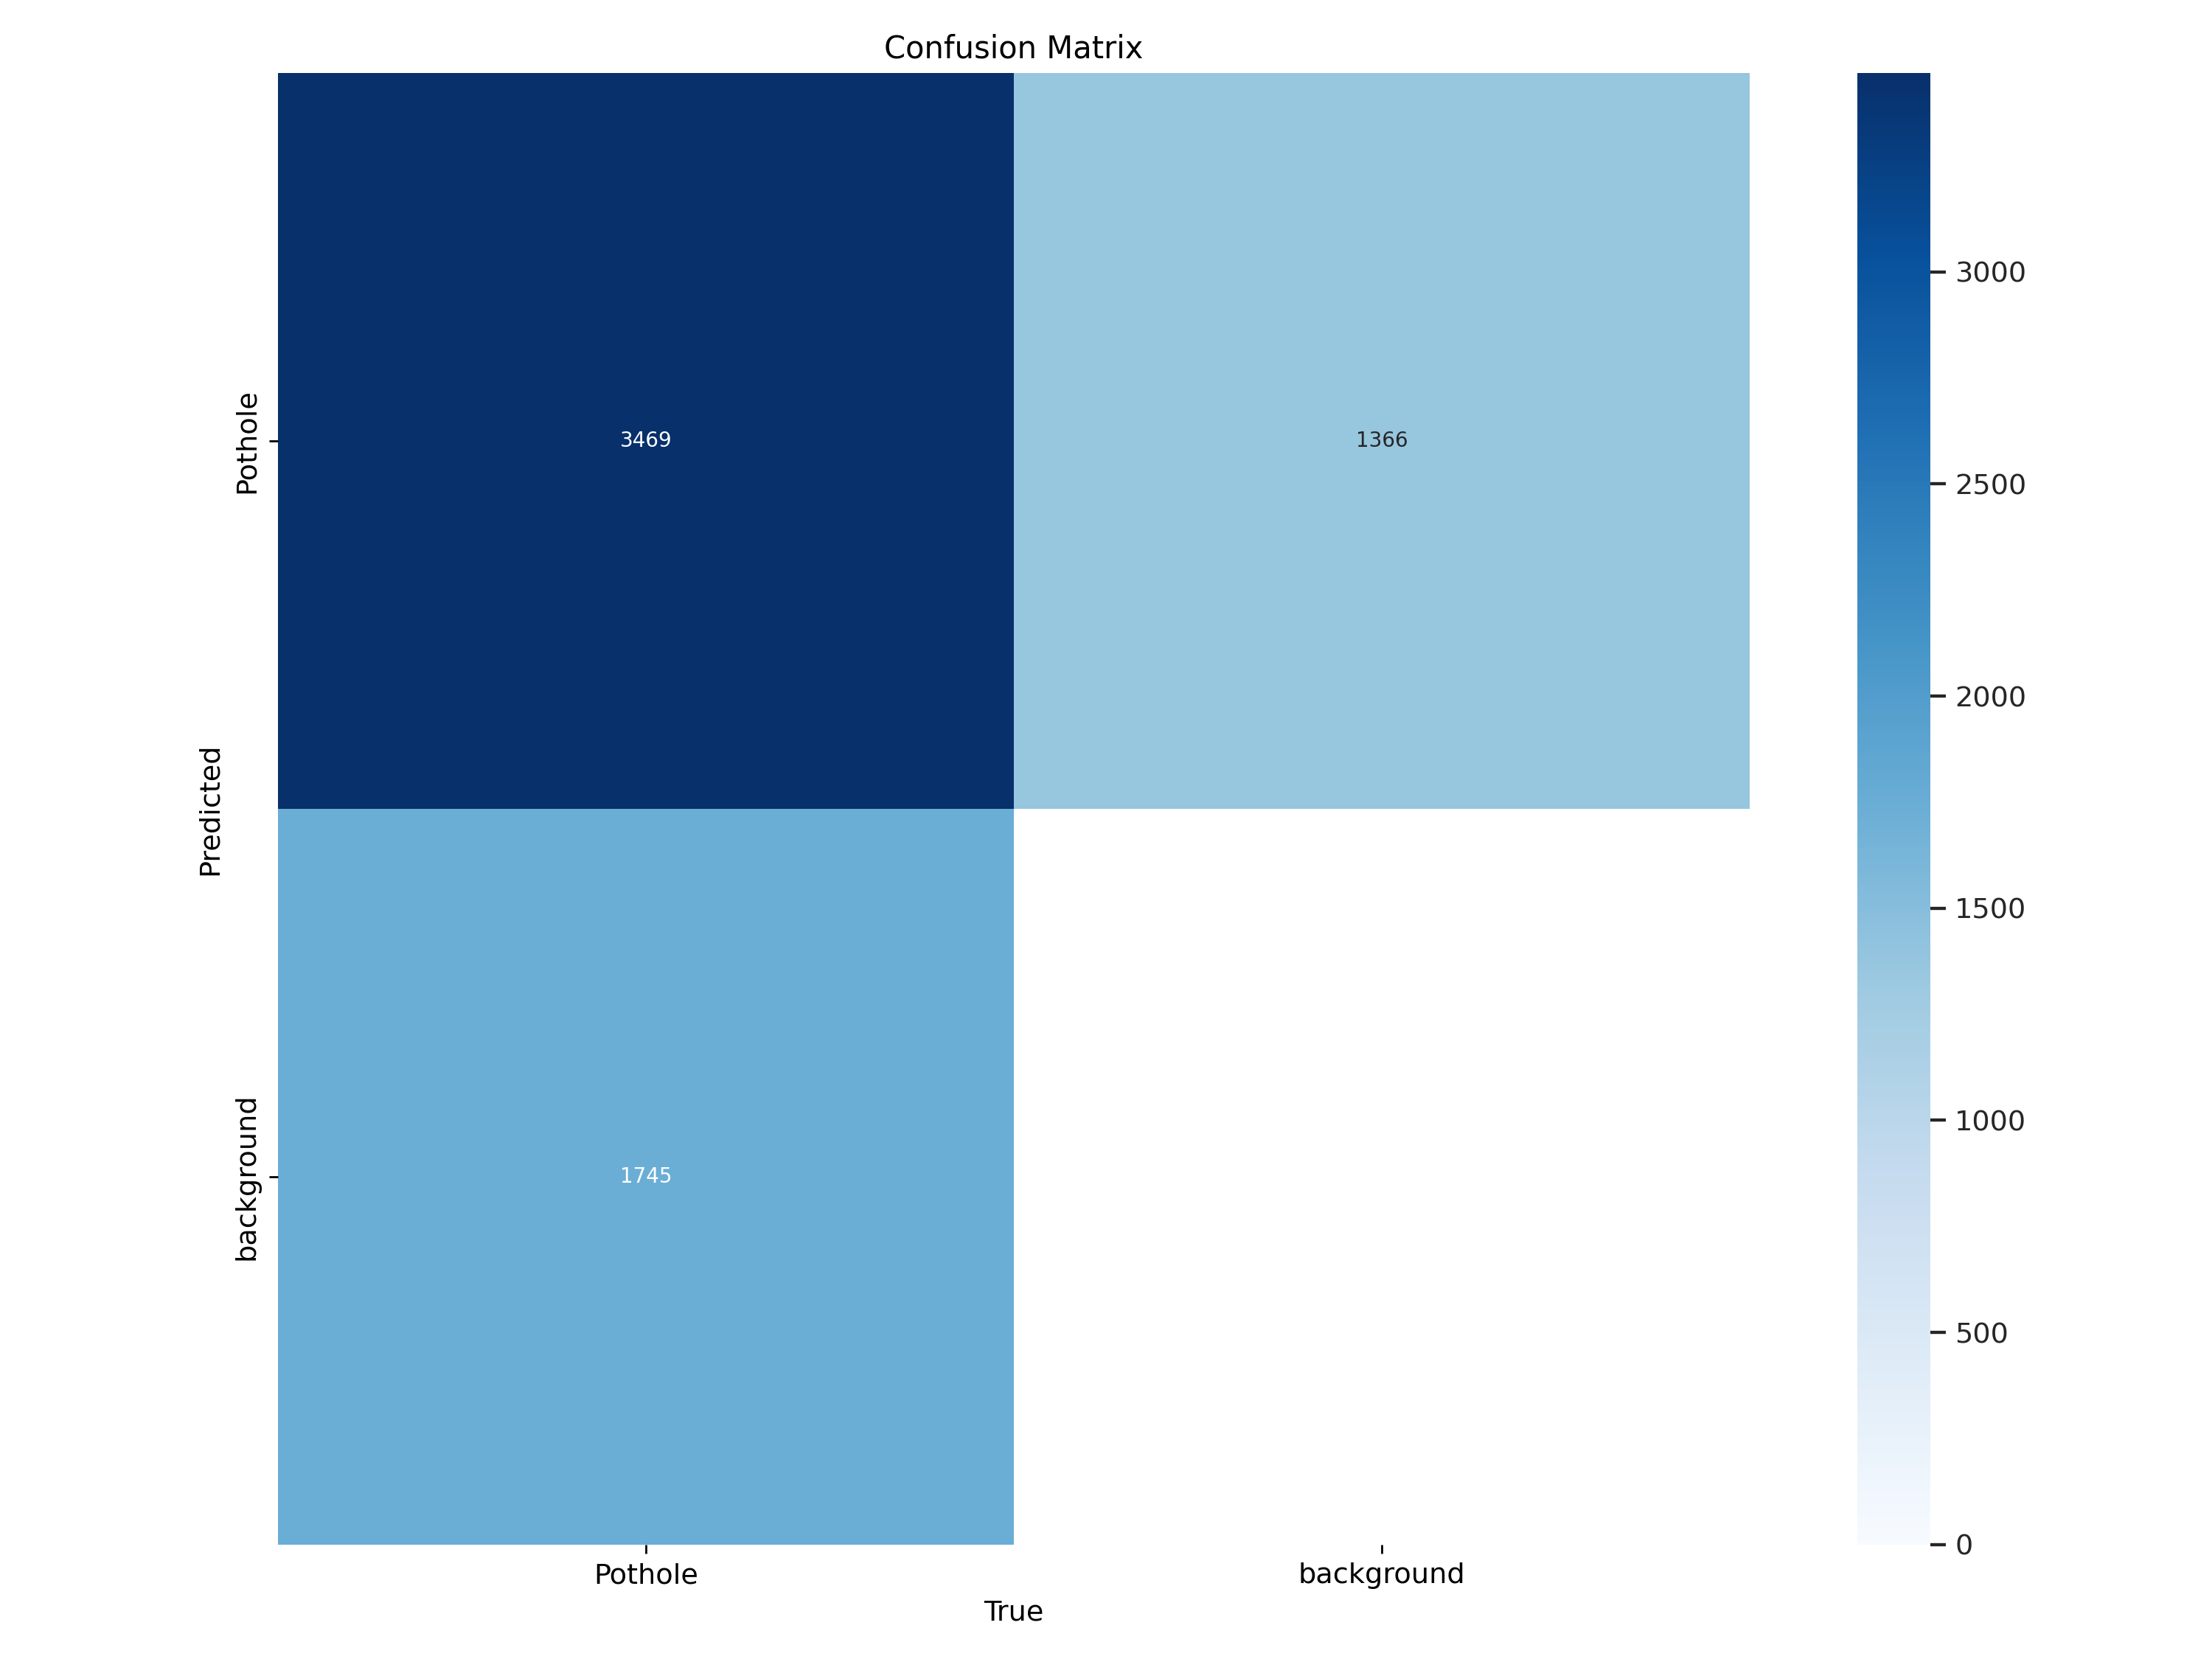

In [15]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train2/confusion_matrix.png', width=1000)

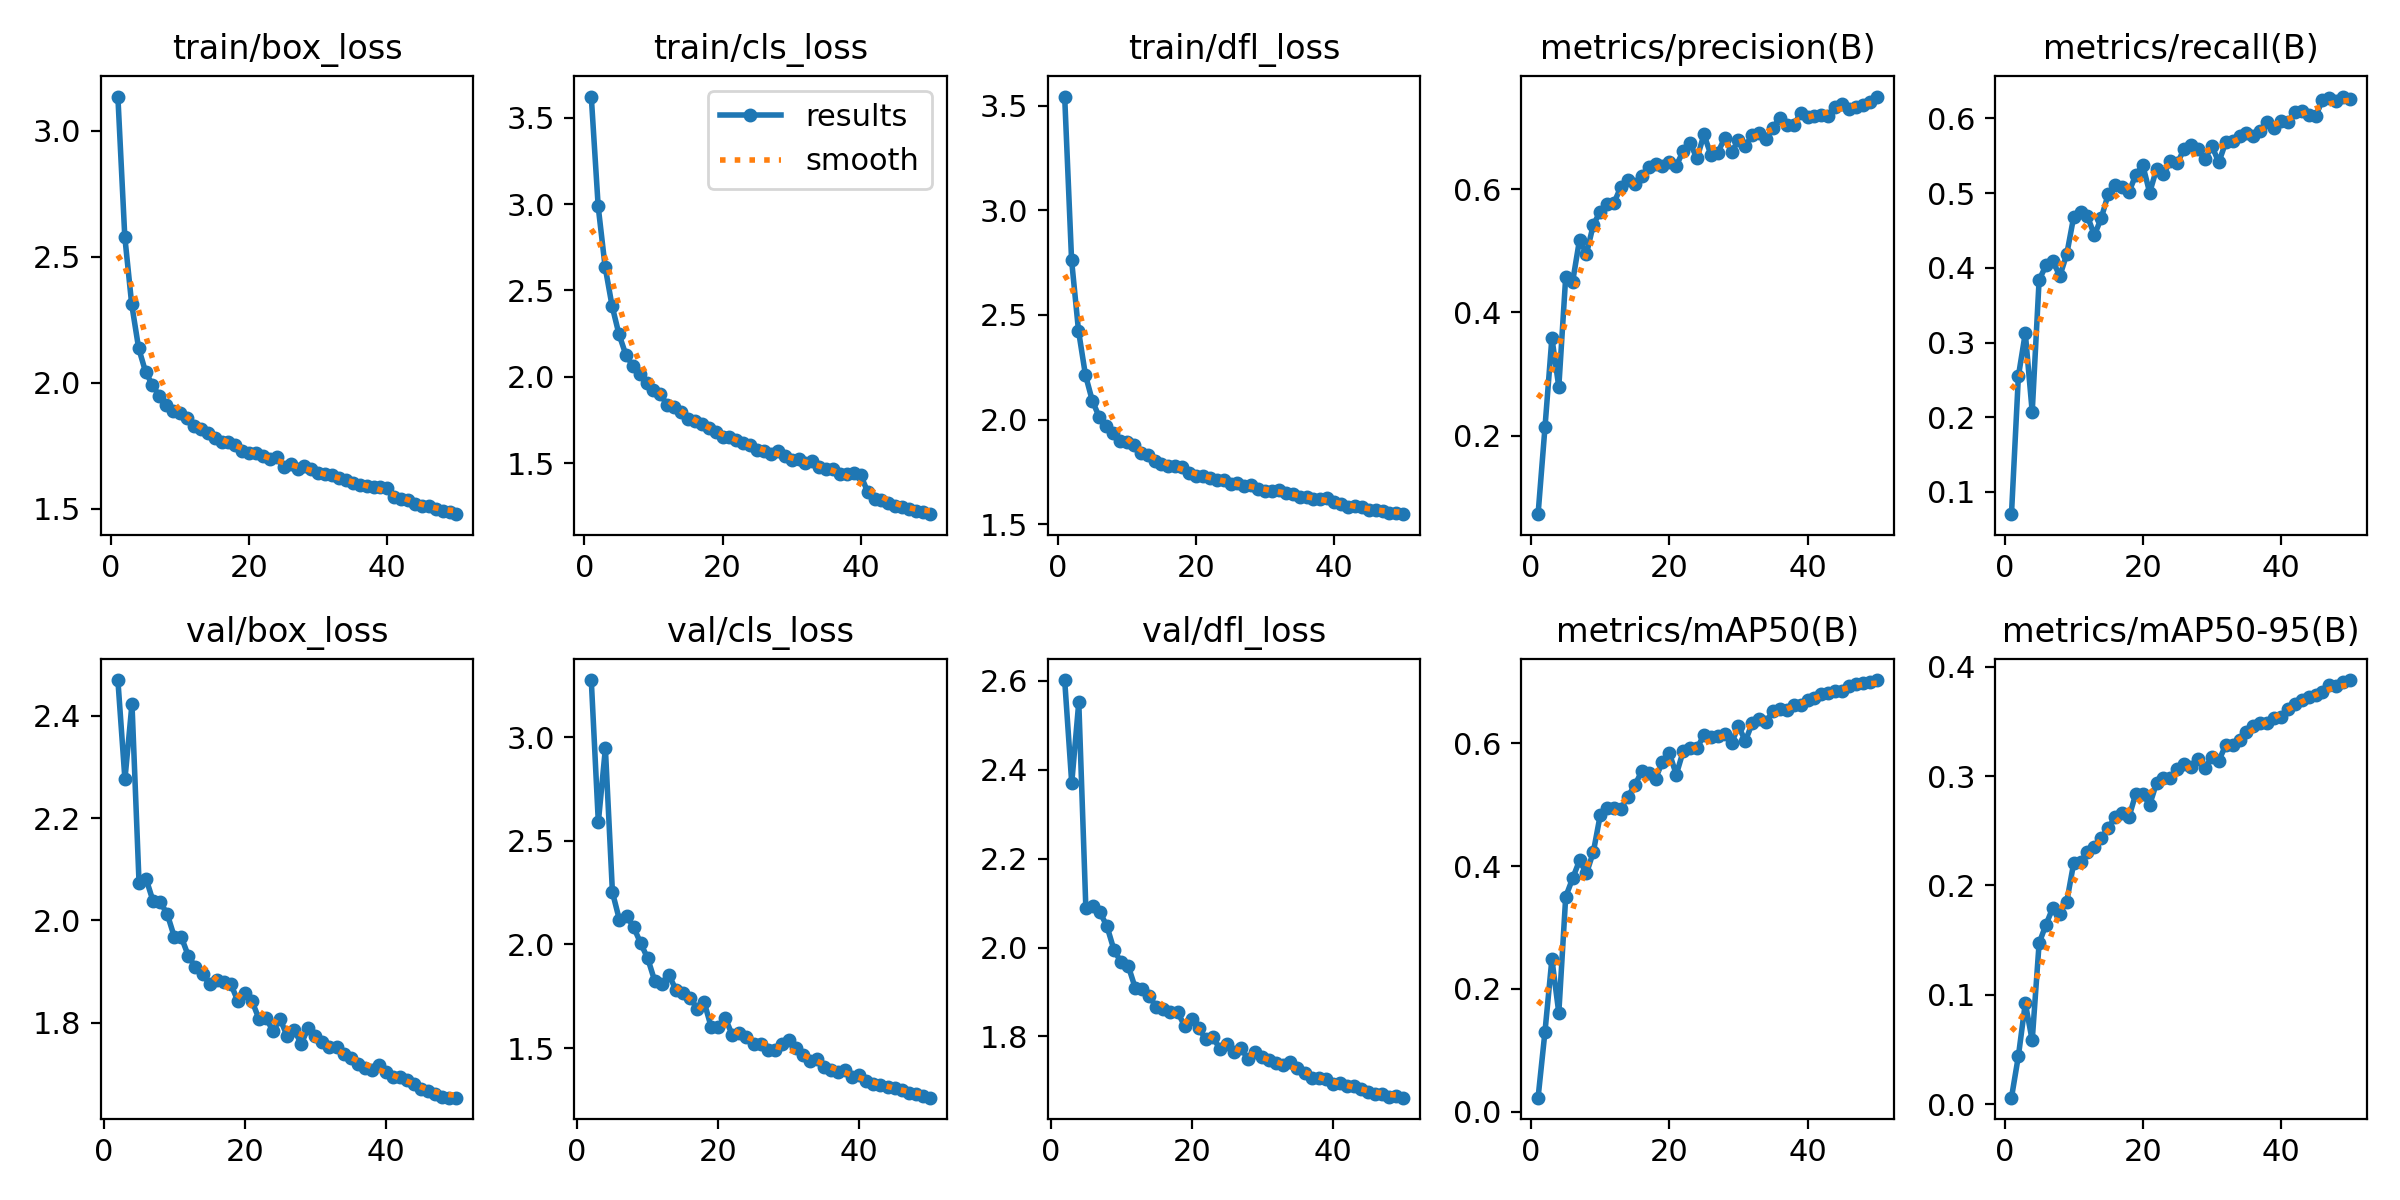

In [16]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train2/results.png', width=1000)

In [17]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Pothole']

In [18]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train2/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [19]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.36439102619322206
mAP 50 0.6226296602879537
mAP 75 0.38188638203054864


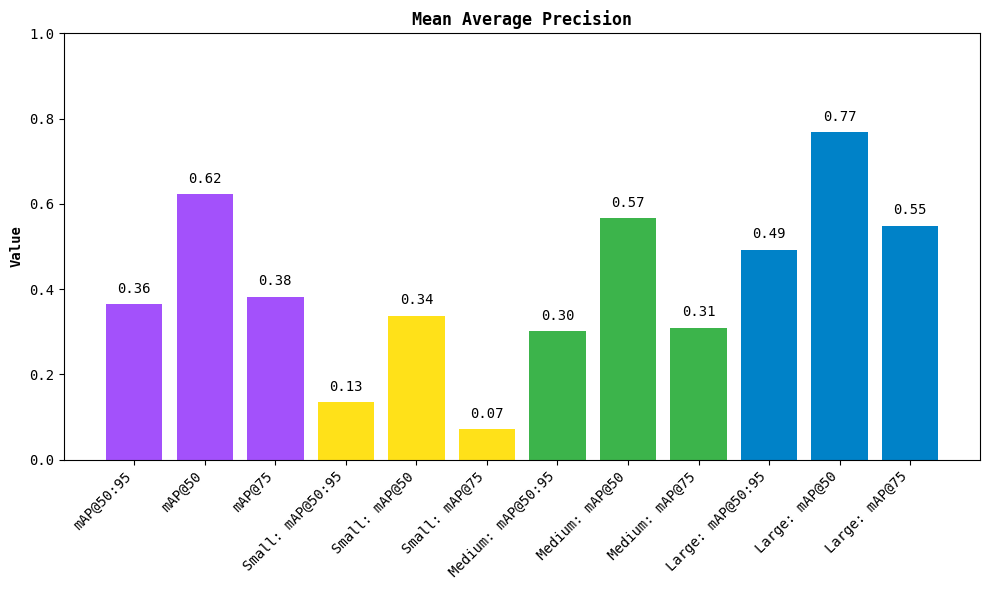

In [20]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [21]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

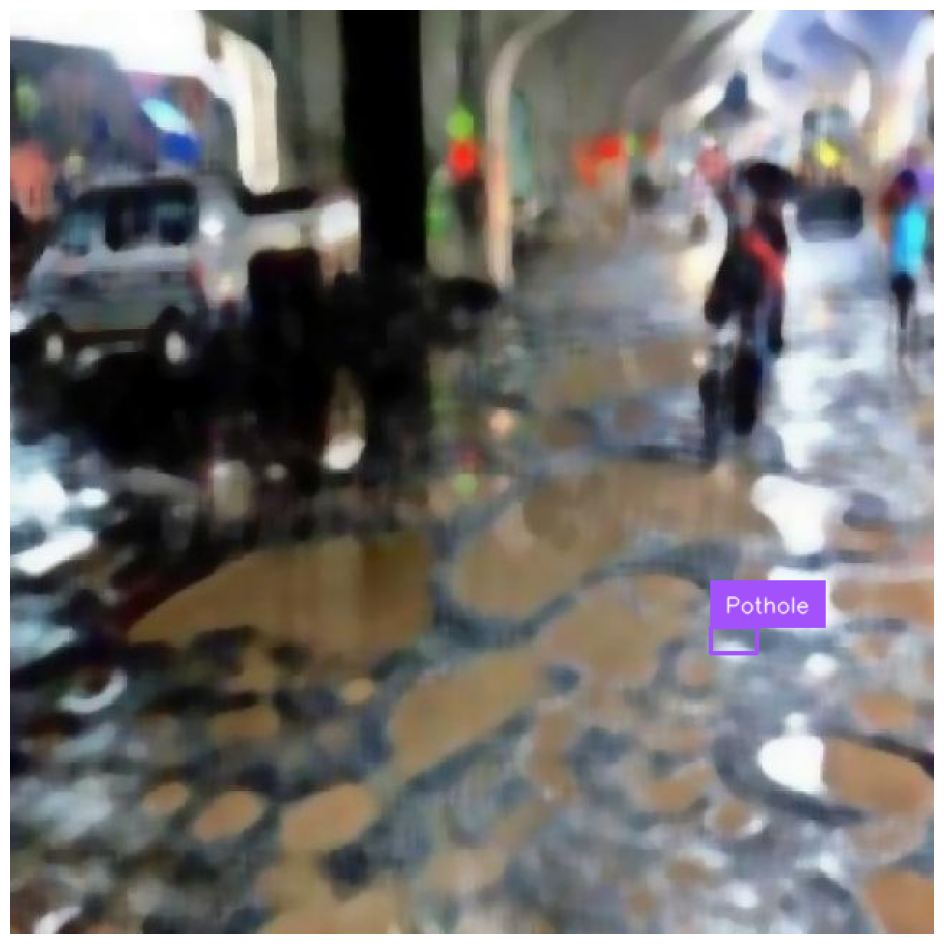

In [40]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)